# La ville du quart d’heure à l’épreuve des services urbains : le cas de Marseille

**Analyse de la connectivité structurelle et de la densité des services via le modèle de Waxman**

---

## Contexte
Marseille, deuxième ville de France, présente une morphologie urbaine complexe caractérisée par un étalement géographique important et une topographie contrainte. Dans le cadre des réflexions actuelles sur la transition écologique, le concept de la "Ville du Quart d'Heure" — visant un accès aux besoins essentiels en moins de 15 minutes de marche ou de vélo — constitue un enjeu majeur de cohésion sociale et de planification urbaine.

## Problématique
Dans quelle mesure la structure du réseau routier marseillais conditionne-t-elle l'accessibilité réelle aux services de santé, de commerce et de loisirs ? L'analyse peut-elle mettre en évidence une rupture de connectivité entre l'hyper-centre historique et les quartiers périphériques, révélant ainsi une fracture de proximité ?

---

## Résumé de l'analyse
Cette étude cartographique modélise les liens entre les services essentiels pour évaluer la réalité de cette proximité. 

Les résultats font apparaître deux configurations géographiques distinctes :
* **Un centre-ville hyper-connecté** : On y observe une forte concentration d'équipements et une connectivité élevée, où le maillage des voies favorise une accessibilité piétonne optimale.
* **Une périphérie fragmentée** : Le réseau y est plus lâche et moins structuré, rendant ces zones largement dépendantes de l'automobile pour l'accès aux services de base.

En conclusion, si le cœur de Marseille s'inscrit dans le modèle de la ville du quart d’heure, les zones périphériques soulignent les défis de fragmentation urbaine auxquels la métropole est confrontée.

---

## Méthodologie
* **Données** : OpenStreetMap via la bibliothèque OSMnx.
* **Modélisation** : Graphes de Waxman (probabilité de connexion basée sur la distance réseau réelle).
* **Paramètre de calcul** : Rayon de 1000 mètres.
* **Environnement technique** : Python (GeoPandas, Matplotlib, Contextily).

---

In [1]:
import os
os.environ["PROJ_LIB"] = r"C:\Users\urbai\.conda\envs\geo_final\Library\share\proj"


In [1]:
# https://city2graph.net/index.html
#!pip install city2graph

import osmnx as ox
import city2graph
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.lines import Line2D  
from shapely.geometry import box

city2graph.__version__

C:\Users\urbai\.conda\envs\geo_final\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.2.3'

##  Analyse de l'offre sportive à Marseille via OpenStreetMap

Ce bloc de code réalise une extraction ciblée des infrastructures de loisirs pour la commune de Marseille. L'objectif est de constituer une base de données de Points d'Intérêt (POI) pour de futures analyses d'accessibilité.

### Méthodologie :
1. **Extraction Géocodée** : Utilisation d'OSMnx pour définir l'emprise administrative précise de Marseille.
2. **Filtrage Thématique** : Récupération des entités taguées `leisure: gym` et `sports_centre`.
3. **Optimisation Géométrique** : 
   * **Projection EPSG:3857** : Passage d'un système de coordonnées géographiques (degrés) à un système projeté (mètres) indispensable pour les opérations spatiales.
   * **Calcul des Centroïdes** : Transformation des emprises au sol (polygones) en points nodaux pour faciliter l'intégration dans un graphe de transport.
4. **Nettoyage** : Purge des données incomplètes pour garantir l'intégrité du dataset final.

<Axes: >

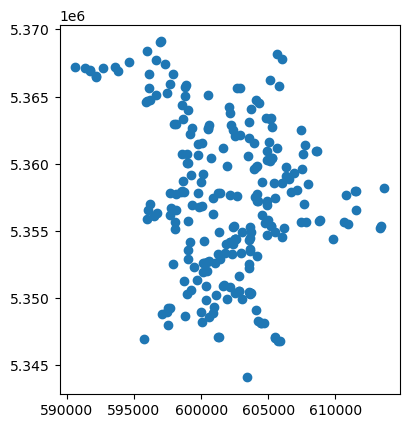

In [2]:
city_name = "marseille"
admin = ox.geocode_to_gdf(city_name)

poi_gdf = ox.features_from_place(city_name, {"leisure": ["gym", "sports_centre"]}).to_crs(3857)
poi_gdf["geometry"] = poi_gdf.geometry.centroid
poi_gdf = poi_gdf.dropna(subset=["geometry"]).reset_index(drop=True)
poi_gdf.head()

poi_gdf.plot()

In [3]:
dir(city2graph)

['PackageNotFoundError',
 '__author__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'add_metapaths',
 'add_metapaths_by_weight',
 'base',
 'bridge_nodes',
 'contextlib',
 'contiguity_graph',
 'create_isochrone',
 'create_tessellation',
 'data',
 'delaunay_graph',
 'dual_graph',
 'euclidean_minimum_spanning_tree',
 'filter_graph_by_distance',
 'fixed_radius_graph',
 'gabriel_graph',
 'gdf_to_nx',
 'gdf_to_pyg',
 'get_od_pairs',
 'graph',
 'group_nodes',
 'is_torch_available',
 'knn_graph',
 'load_gtfs',
 'load_overture_data',
 'metapath',
 'mobility',
 'morphological_graph',
 'morphology',
 'nx_to_gdf',
 'nx_to_pyg',
 'nx_to_rx',
 'od_matrix_to_graph',
 'plot_graph',
 'private_to_private_graph',
 'private_to_public_graph',
 'process_overture_segments',
 'proximity',
 'public_to_public_graph',
 'pyg_to_gdf',
 'pyg_to_nx',
 'relative_neighborhood_graph',
 'rx_to_nx',
 'segments_to_graph',
 

### Fonction de visualisation avancée : Graphes Urbains (Style Dark)

Cette fonction, `plot_pub_graph`, est conçue pour générer des cartographies à haute valeur esthétique. Elle automatise le rendu d'un réseau (graphe) sur un fond de carte sombre.

**Points clés du script :**
* **Reprojection à la volée** : Force l'affichage en **EPSG:3857** pour assurer la superposition parfaite avec les tuiles de fond de carte.
* **Esthétique "Dark Matter"** : Utilisation du fournisseur *CartoDB.DarkMatterNoLabels* pour faire ressortir les axes de transport en couleur néon (Cyan par défaut).
* **Composition Multi-couches** : 
    1. **Boundary** : Les limites administratives de la ville.
    2. **Edges** : Le réseau de rues ou de transport (les arêtes).
    3. **Basemap** : Le fond de carte contextuel.
* **Nettoyage Graphique** : Suppression des axes (latitude/longitude) pour un rendu épuré type "Data Viz".

In [4]:
def plot_pub_graph(edges_gdf, nodes_gdf, admin_gdf, title, color="#00FFFF", alpha=0.5, linewidth=0.75):
    """
    Génère une carte stylisée du réseau urbain.
    """
    # Création de la figure avec un format carré
    fig, ax = plt.subplots(figsize=(5, 5))

    # Affichage des limites administratives (en blanc transparent)
    admin_gdf.to_crs(epsg=3857).boundary.plot(ax=ax, color="white", linewidth=1.0, alpha=0.4)
    
    # Affichage du réseau (les rues/arêtes)
    edges_gdf.to_crs(epsg=3857).plot(ax=ax, color=color, linewidth=linewidth, alpha=alpha)
    
    # Ajout du fond de carte sombre (CartoDB)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels)
    
    # Mise en forme esthétique
    ax.set_axis_off()
    ax.set_title(title, fontsize=14, color="black", pad=12) 
    
    plt.tight_layout()
    plt.show()

###  Modélisation du graphe de proximité (Rayon Fixe)

Cette étape transforme nos points d'intérêt (POI) en un réseau interconnecté pour analyser la densité spatiale :

1. **Calcul de connectivité** : Utilisation de la méthode `fixed_radius_graph` avec un seuil de **2500 mètres**. 
2. **Analyse de voisinage** : Une liaison (arête) est créée entre deux infrastructures si la distance qui les sépare est inférieure au rayon défini.
3. **Visualisation** : Rendu cartographique permettant d'identifier visuellement les grappes (clusters) d'équipements sportifs à Marseille.

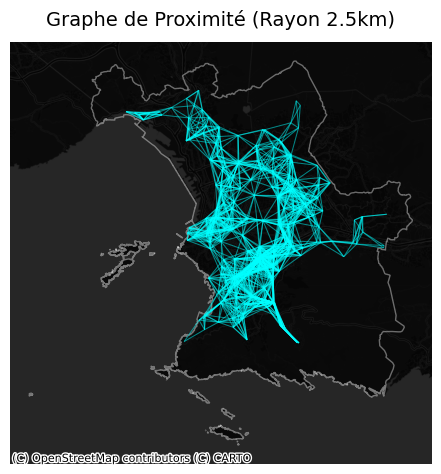

In [5]:
radius = 2500
fixed_nodes, fixed_edges = city2graph.fixed_radius_graph(poi_gdf, radius=radius)

plot_pub_graph(fixed_edges, poi_gdf, admin, "Graphe de Proximité (Rayon 2.5km)", color="#00FFFF")

###  Modélisation par Graphe de Waxman (Métrique Manhattan)

On utilise ici un modèle probabiliste pour simuler des interdépendances plus complexes entre les équipements sportifs :

1. **Modèle de Waxman** : La probabilité de connexion décroît exponentiellement avec la distance. Cela permet de modéliser des réseaux plus réalistes où des connexions à longue distance restent possibles mais rares.
2. **Métrique Manhattan** : Calcul de la distance "en bloc de ville" (City Block), plus représentative des déplacements urbains que la simple ligne droite.
3. **Paramètres** : 
   * `beta=0.5` : Densité moyenne du réseau.
   * `r0=2500` : Portée caractéristique des connexions.

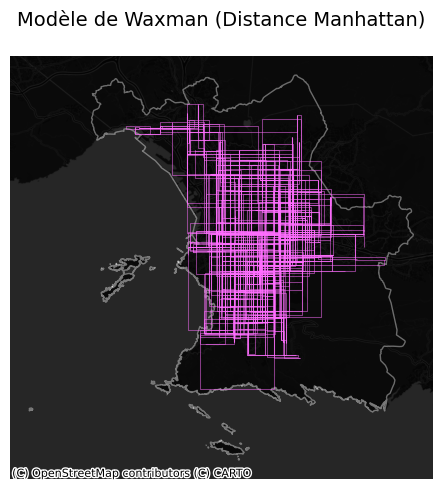

In [6]:
# Génération du graphe de Waxman
# Utilisation de la distance Manhattan pour plus de réalisme urbain
wax_l1_nodes, wax_l1_edges = city2graph.waxman_graph(
    poi_gdf,
    distance_metric="manhattan",
    r0=radius,
    beta=0.5
)

# Visualisation avec un style néon Rose/Magenta
plot_pub_graph(
    wax_l1_edges, 
    poi_gdf, 
    admin, 
    "Modèle de Waxman (Distance Manhattan)", 
    color="#FF6EFF"
)

###  Modélisation par Graphe de Waxman (Métrique Euclidienne)

Dernier volet de la comparaison des modèles de réseaux, ce script utilise la distance "à vol d'oiseau" :

1. **Métrique Euclidienne** : Calcul de la distance directe (racine carrée de la somme des carrés des différences). C'est le standard pour les analyses de proximité théoriques.
2. **Impact sur le réseau** : À paramètres égaux (`beta` et `r0`), cette métrique génère généralement un graphe plus dense que la métrique Manhattan, car les distances calculées sont plus courtes.
3. **Objectif** : Comparer la sensibilité du modèle de Waxman aux différentes méthodes de calcul de distance pour choisir la plus pertinente pour le terrain marseillais.

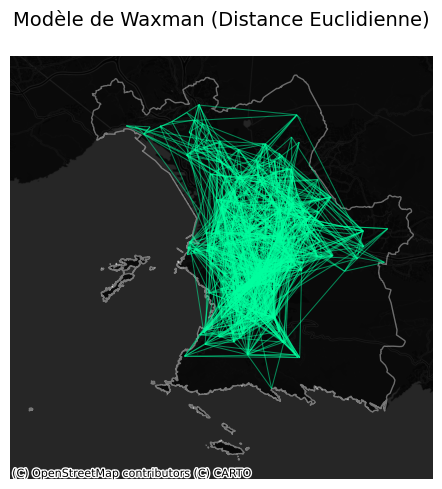

In [7]:
# Génération du graphe de Waxman avec distance euclidienne
wax_l2_nodes, wax_l2_edges = city2graph.waxman_graph(
    poi_gdf,
    distance_metric="euclidean",
    r0=radius,
    beta=0.5
)

# Visualisation avec un style Vert Printemps / Néon
plot_pub_graph(
    wax_l2_edges, 
    poi_gdf, 
    admin, 
    "Modèle de Waxman (Distance Euclidienne)", 
    color="#00FF9F"
)

### Modélisation par Graphe de Waxman (Distance Réseau Réelle)

Cette analyse représente le plus haut niveau de réalisme en intégrant les contraintes physiques du territoire marseillais :

1. **Extraction du réseau routier** : Récupération via OSMnx de la topologie réelle des rues (mode "drive").
2. **Métrique Réseau (Network)** : La probabilité de connexion entre deux points n'est plus basée sur une distance mathématique, mais sur la distance réelle de parcours routier. 
3. **Prise en compte des obstacles** : Ce modèle intègre naturellement les barrières urbaines (fleuves, voies ferrées, reliefs) qui dictent la véritable connectivité entre les infrastructures sportives.
4. **Visualisation** : Rendu en orange pour souligner l'utilisation des données d'infrastructure de transport.

<Figure size 640x480 with 0 Axes>

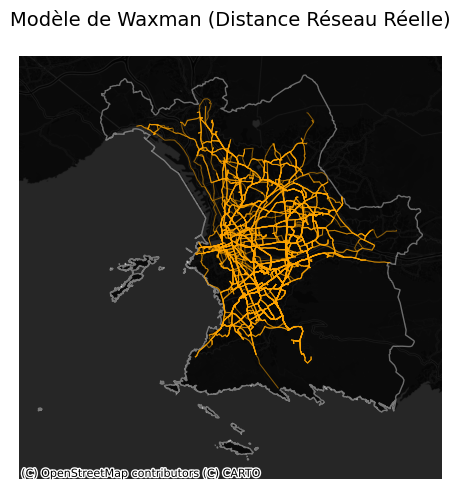

In [15]:
# 1. Extraction du réseau de rues réel (en mètres 3857)
segments_gdf = ox.graph_to_gdfs(ox.graph_from_place(city_name, network_type="drive"))[1].to_crs(3857)

# 2. Génération du graphe de Waxman basé sur le réseau routier
wax_net_nodes, wax_net_edges = city2graph.waxman_graph(
    poi_gdf,
    distance_metric="network",
    r0=radius,
    beta=0.5,
    network_gdf=segments_gdf
)
# 3. Visualisation avec un style Orange Vif
plot_pub_graph(
    wax_net_edges, 
    poi_gdf, 
    admin, 
    "Modèle de Waxman (Distance Réseau Réelle)", 
    color="#FFA500"
)



###  Segmentation Thématique des Services Urbains (Marseille)

Ce script automatise la collecte de données pour quatre piliers majeurs de la vie citadine. L'objectif est de comparer l'accessibilité de différentes catégories de services :

1. **Structuration des données** : Organisation des requêtes par thématiques (Vie active, Besoins quotidiens, Vie sociale, Santé).
2. **Filtrage Géométrique** : Extraction exclusive des points (nœuds) pour garantir la compatibilité avec les algorithmes de calcul de distance réseau.
3. **Indicateurs de densité** : Le script affiche le volume d'entités trouvées pour chaque catégorie, permettant une première évaluation de l'offre de services à Marseille.

In [21]:
city_name = "Marseille, France"
# Préparation des fonds de carte et réseaux
admin = ox.geocode_to_gdf(city_name).to_crs(3857)
segments_gdf = ox.graph_to_gdfs(ox.graph_from_place(city_name, network_type="drive"))[1].to_crs(3857)

# Définition des catégories d'analyse
poi_queries = {
    "active_life": {"leisure": ["gym", "sports_centre"]},
    "daily_needs": {"shop": ["supermarket", "convenience"]},
    "social_life": {"amenity": ["restaurant"]},
    "health_services": {"amenity": ["hospital", "clinic", "pharmacy"]}
}

poi_layers = {}

# Boucle d'extraction automatisée
for label, query in poi_queries.items():
    # Récupération des données OSM
    poi = ox.features_from_place(city_name, query).to_crs(3857)
    
    # On ne garde que les points pour l'analyse de réseau
    poi_layers[label] = poi[poi.geometry.type == "Point"].copy()
    
    # Affichage du diagnostic
    print(f" {label} : {len(poi_layers[label])} points extraits")

 active_life : 36 points extraits
 daily_needs : 444 points extraits
 social_life : 1045 points extraits
 health_services : 390 points extraits


###  Génération Multi-thématique des Graphes de Waxman (Réseau)

Ce script génère une série de modèles de connectivité réelle pour chaque catégorie de services à Marseille :

1. **Analyse Comparative** : Application systématique du modèle de Waxman aux quatre couches (Santé, Sport, Social, Besoins).
2. **Paramètre de Proximité (1 km)** : Utilisation d'un rayon de 1000m pour simuler les interactions de voisinage et l'accessibilité locale.
3. **Métrique Réseau Dynamique** : Les connexions sont calculées en fonction de la topologie réelle des rues, intégrant ainsi les barrières urbaines propres à Marseille.
4. **Indicateurs de Structure** : Ce dictionnaire de graphes permet d'identifier quelle thématique de services est la mieux intégrée au tissu urbain.

In [22]:
wax_graphs = {}
# Rayon réduit à 1km pour une analyse de proximité locale
radius = 1000

for label, gdf in poi_layers.items():
    # Vérification qu'il y a assez de points pour créer un graphe
    if len(gdf) > 1:
        print(f" Calcul du graphe réseau pour : {label}...")
        
        nodes, edges = city2graph.waxman_graph(
            gdf,
            distance_metric="network",
            r0=radius,          
            beta=0.5,
            network_gdf=segments_gdf
        )
        # On stocke les arêtes résultantes
        wax_graphs[label] = edges
    else:
        print(f" Pas assez de données pour {label}")

print("\n Tous les graphes de Waxman (Network) ont été générés.")

 Calcul du graphe réseau pour : active_life...
 Calcul du graphe réseau pour : daily_needs...
 Calcul du graphe réseau pour : social_life...
 Calcul du graphe réseau pour : health_services...

 Tous les graphes de Waxman (Network) ont été générés.


In [12]:
len(wax_graphs)

4

###  Charte Graphique et Sémiologie de l'Analyse

Pour garantir la lisibilité des résultats multi-thématiques, une charte graphique spécifique est appliquée. Ce choix de couleurs "Néon" sur fond sombre permet de :

1. **Différencier les réseaux** : Identifier au premier coup d'œil quel service est représenté.
2. **Accentuer les contrastes** : Faire ressortir la densité des connexions (les arêtes du graphe) par rapport à la morphologie urbaine de Marseille.
3. **Harmoniser le rendu** : Assurer une cohérence visuelle entre les quatre cartes thématiques lors de la présentation finale.

In [23]:
# Définition de la palette de couleurs pour chaque thématique
layer_colors = {
    "active_life": "#00e5ff",       # Cyan néon (Sport/Gym)
    "daily_needs": "#ffea00",       # Jaune vif (Supermarchés)
    "social_life": "#ff4081",       # Rose néon (Restaurants)
    "health_services": "#76ff03"    # Vert lime (Santé/Pharmacies)
}

print(" Charte graphique configurée avec succès.")

 Charte graphique configurée avec succès.


###  Synthèse Globale 

Ce rendu final agrège l'ensemble des réseaux de services (Sport, Santé, Social, Commerce) sur une cartographie unique pour analyser les interdépendances urbaines :

1. **Superposition Multidimensionnelle** : Visualisation simultanée des quatre piliers de la "ville du quart d'heure".
2. **Analyse de la Mixité Fonctionnelle** : Les zones où les couleurs s'entremêlent révèlent les pôles de centralité de Marseille (ex: Vieux-Port, Castellane).
3. **Hiérarchie Visuelle (Z-Order)** : Gestion fine de l'affichage pour maintenir la lisibilité des points d'intérêt malgré la densité des réseaux de transport simulés.
4. **Diagnostic Territorial** : Identification immédiate des zones de déconnexion ou des déserts de services par l'absence de couleur sur le fond de carte sombre.

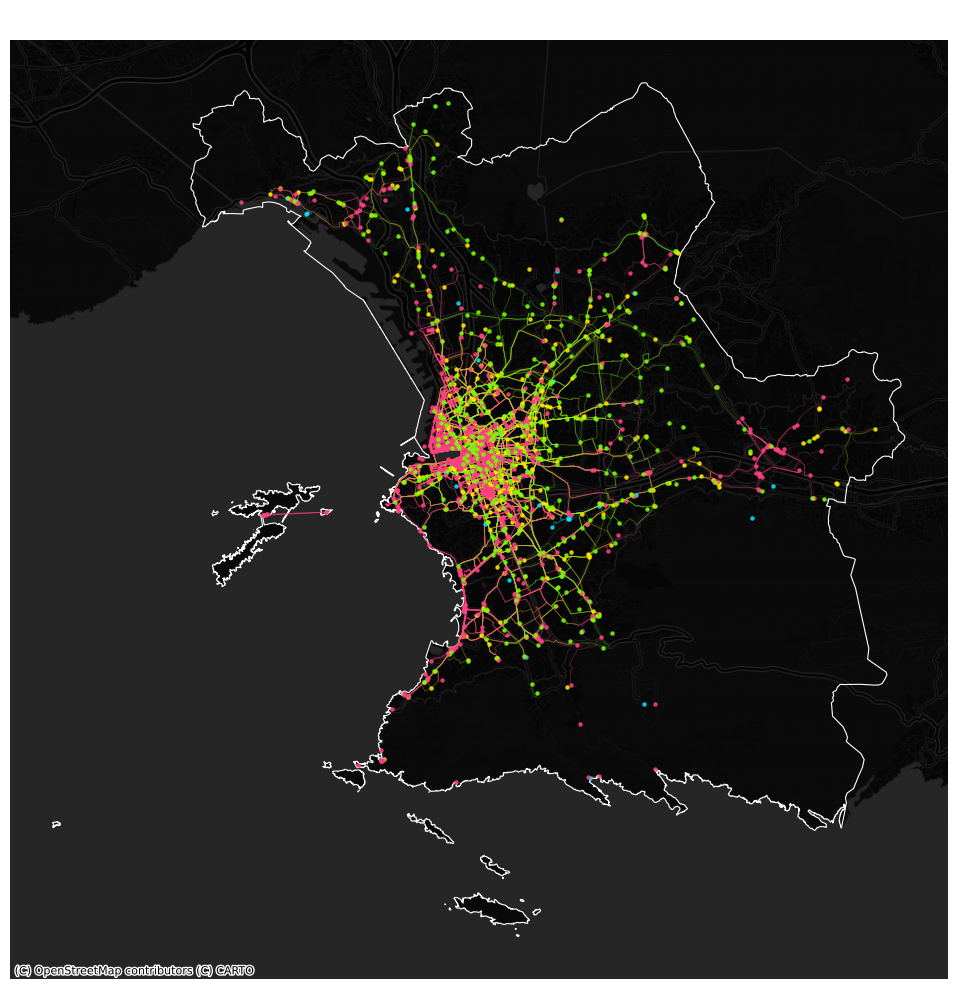

In [14]:
# Création de la figure finale (Grand format pour les détails)
fig, ax = plt.subplots(figsize=(10, 10))

# 1. Limites administratives
admin.to_crs(3857).boundary.plot(ax=ax, color="white", linewidth=0.8, zorder=5)

# 2. Dessin de toutes les arêtes (les liens entre services)
for label, edges in wax_graphs.items():
    # On itère sur chaque segment pour un contrôle précis
    for _, row in edges.iterrows():
        x, y = row.geometry.xy
        ax.plot(x, y, color=layer_colors[label], linewidth=0.6, alpha=0.3, zorder=6)

# 3. Dessin de tous les points (les équipements)
for label, pois in poi_layers.items():
    pois.to_crs(3857).plot(ax=ax, markersize=5, color=layer_colors[label], alpha=0.8, zorder=7)

# 4. Titre et cosmétique
ax.set_title(
    "Graphes de Waxman (Réseau) – Connectivité de la vie quotidienne à Marseille",
    fontsize=13,
    color="white", # 'black' si le fond de ton logiciel est blanc
    pad=12
)

# 5. Fond de carte et finalisation
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels, crs=3857, zoom=12)

ax.set_axis_off()
plt.tight_layout()

os.makedirs("resultats", exist_ok=true)
plt.savefig(f"resultats/carte_{city_name}.png",bbox_inches="tight",dpi=300)

plt.show()

In [24]:
def plot_city_connectivity(city_name, admin, wax_graphs, radius):
    """
    Trace une carte de connectivité urbaine (style sombre) et l'enregistre en PNG.
    """

    # --- Initialisation de la figure (Format carré, fond noir) ---
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.patch.set_facecolor("black")

    # --- 1. Tracé des limites de la ville (Bordure grise) ---
    admin.boundary.plot(
        ax=ax,
        color="dimgrey",
        linewidth=2.0,
        zorder=5,
        alpha=0.6
    )

    # --- 2. Tracé des couches de connectivité (Les lignes de ton analyse) ---
    for label in ["daily_needs", "health_services", "education", "active_life"]:
        edges = wax_graphs.get(label)
        if edges is None or edges.empty:
            continue

        color = layer_colors[label]

        # On parcourt chaque connexion générée par ton modèle
        for _, row in edges.iterrows():
            x, y = row.geometry.xy
            # Effet de "lueur" (glow) : une ligne large très transparente
            ax.plot(x, y, color=color, linewidth=2.0, alpha=0.05, zorder=6)
            # Ligne principale : fine et nette
            ax.plot(x, y, color=color, linewidth=0.6, alpha=0.3, zorder=7)

    # --- 3. Ajout du fond de carte (Basemap DarkMatter) ---
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.DarkMatterNoLabels,
        crs=admin.crs,
        zoom=12
    )

    ax.set_axis_off()

    # --- 4. Calcul du zoom automatique ---
    # On récupère les limites de toutes les couches pour centrer la carte
    all_bounds = [gdf.total_bounds for gdf in wax_graphs.values() if not gdf.empty]

    minx = min(b[0] for b in all_bounds)
    miny = min(b[1] for b in all_bounds)
    maxx = max(b[2] for b in all_bounds)
    maxy = max(b[3] for b in all_bounds)

    # Ajout de marges pour que le dessin ne touche pas les bords
    buffer_x = (maxx - minx) * 0.05
    buffer_y = (maxy - miny) * 0.05
    extra_bottom = (maxy - miny) * 0.1 # Espace pour la légende en bas

    ax.set_xlim(minx - buffer_x, maxx + buffer_x)
    ax.set_ylim(miny - buffer_y - extra_bottom, maxy + buffer_y + 0.05)

    # --- 5. Masquage (L'astuce pour cacher l'extérieur de la ville) ---
    outer_box = box(minx - buffer_x, miny - buffer_y, maxx + buffer_x, maxy + buffer_y)
    city_shape = admin.geometry.unary_union
    mask_geom = outer_box.difference(city_shape) # On crée un "trou" de la forme de la ville

    # On peint en noir tout ce qui est en dehors de la ville
    gpd.GeoSeries([mask_geom], crs=admin.crs).plot(
        ax=ax,
        color="black",
        zorder=4
    )

    # --- 6. Légende personnalisée ---
    legend_elements = [
        Line2D([0], [0], color=color, lw=3, label=label.replace("_", " ").title())
        for label, color in layer_colors.items()
    ]

    ax.legend(
        handles=legend_elements,
        loc="lower left",
        bbox_to_anchor=(0.02, -0.02),
        frameon=True,
        framealpha=1,
        facecolor="black",
        edgecolor="black",
        fontsize=9,
        labelcolor="white",
        title="  " + city_name.split(",")[0],
        title_fontproperties={"weight": "bold", "size": 10}
    )

    # --- 7. SAUVEGARDE (C'est ici que ton fichier se crée) ---
    plt.tight_layout()
    plt.savefig(
        city_name.replace(",", "").replace(" ", "_") + "_connectivity_" + str(radius) + ".png",
        bbox_inches="tight",
        pad_inches=0,
        dpi=300,
        facecolor="black",
        edgecolor="black",
        transparent=False
    )

    plt.show() # Affiche le résultat dans ton notebook

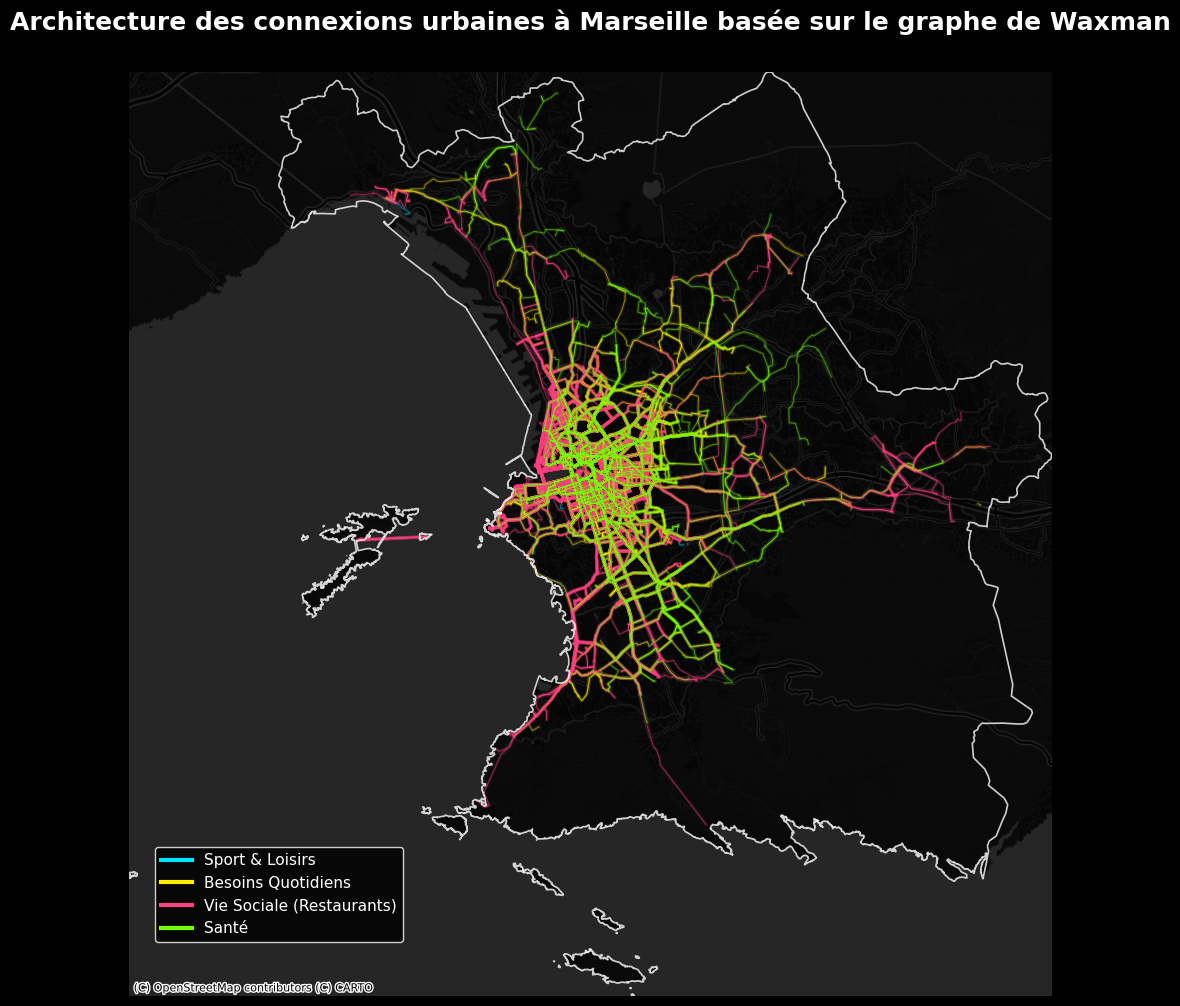

In [29]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.lines import Line2D

def plot_marseille_fixed(city_name, admin, wax_graphs, radius):
    # 1. Création de la figure
    fig, ax = plt.subplots(figsize=(12, 12), facecolor='black')
    
    # 2. Tracé des contours de Marseille (en blanc pour qu'ils ressortent)
    admin.boundary.plot(ax=ax, color="white", linewidth=1.2, zorder=10, alpha=0.8)

    # 3. Tracé des réseaux Waxman
    labels_fr = {
        "active_life": "Sport & Loisirs",
        "daily_needs": "Besoins Quotidiens",
        "social_life": "Vie Sociale (Restaurants)",
        "health_services": "Santé"
    }

    # On trace les réseaux
    for label, edges in wax_graphs.items():
        if edges is None or edges.empty:
            continue
        
        color = layer_colors.get(label, "#FFFFFF")
        # On trace chaque segment avec l'effet néon
        for _, row in edges.iterrows():
            x, y = row.geometry.xy
            # Lueur (glow)
            ax.plot(x, y, color=color, linewidth=2.5, alpha=0.1, zorder=5)
            # Ligne centrale
            ax.plot(x, y, color=color, linewidth=0.7, alpha=0.5, zorder=6)

    # 4. Fond de carte DarkMatter
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels, crs=admin.crs)

 # 5. TITRE (Architecture des connexions urbaines)
    plt.title("Architecture des connexions urbaines à Marseille basée sur le graphe de Waxman", 
              color="white", fontsize=18, pad=30, fontweight='bold')

    # 6. LÉGENDE 
    legend_elements = [
        Line2D([0], [0], color=layer_colors[k], lw=3, label=labels_fr.get(k, k))
        for k in wax_graphs.keys() if k in layer_colors
    ]

    # bbox_to_anchor=(0.02, 0.05) décolle la légende du bord bas (0.05)
    ax.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=(0.02, 0.05),
              facecolor="black", edgecolor="white", labelcolor="white", 
              fontsize=11, framealpha=0.8)


    # 7.  cadrage sur Marseille pour éviter le "tout noir"
    bounds = admin.total_bounds # [minx, miny, maxx, maxy]
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    
    ax.set_axis_off()

    # 8. Sauvegarde avant affichage
    plt.savefig(f"Marseille_Analyse_{radius}m.png", dpi=300, facecolor='black', bbox_inches='tight')
    plt.show()

# Appel de la fonction
plot_marseille_fixed("Marseille", admin, wax_graphs, radius)